# CNN :  Google Bert Augmented Resturant data

In [1]:
# COLAB
from google.colab import files
from google.colab import drive
# SYS
import sys
# IPYNB
!pip install import-ipynb
import import_ipynb
# UTIL
import importlib.util

In [2]:
import pandas as pd
import re
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Activation , Flatten
from sklearn.preprocessing import LabelEncoder
from keras import utils as np_utils
from tensorflow.keras.layers import Dropout,Embedding , BatchNormalization
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
import xgboost as xgb 
import sklearn.metrics as metrics

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Loading preprocessing class

In [4]:
#https://stackoverflow.com/questions/62117483/import-module-in-google-colab-from-google-drive-python
sys.path.append('/content/gdrive/MyDrive/CS--2/')
#import module_1_xml_to_df
#from module_1_xml_to_df import convert_xml_to_DataFrame
from module_2_preprocessing import Data_Preprocessing

Uninstalling nltk-3.5:
  Would remove:
    /usr/local/bin/nltk
    /usr/local/lib/python3.6/dist-packages/nltk-3.5.dist-info/*
    /usr/local/lib/python3.6/dist-packages/nltk/*
Proceed (y/n)? n
Requirement already up-to-date: nltk in /usr/local/lib/python3.6/dist-packages (3.5)
{"don't", 'for', 'haven', "that'll", 'mustn', 'has', 'below', 'is', "shouldn't", 'in', 'than', 'did', 'they', 'the', 'didn', 'ma', 'these', 'my', 'he', 'll', 'of', 'herself', 'myself', 'most', 'be', 'our', 'should', 're', 'hadn', 'hasn', 'from', 'd', 'don', "wasn't", 'themselves', 'not', 'there', 'where', 'again', 'y', 'it', 'had', 'just', 'above', 'against', 'by', 'because', "weren't", 'same', "needn't", 'itself', 'up', 'you', 'down', 'then', 'that', 'aren', 'am', 'after', 'm', 'or', 'if', 'until', "wouldn't", 'we', 'when', 'which', 'why', 'only', 'doesn', 'yours', 'very', 'o', 'a', 'to', 'have', "she's", 'are', "you're", "should've", "mustn't", 'about', 'some', 'wasn', 'his', 'were', 'hers', "you'll", 'during'

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 1. Loading the data

In [5]:
restaurant_data = pd.read_csv("/content/gdrive/MyDrive/CS--2/augmented_data_restaurant_bert.csv")

In [6]:
restaurant_data.shape

(6088, 5)

In [7]:
restaurant_data.head()

,id,text,aspect_term,aspect_category,polarity
0,141.0,this dish is my favorite and i always get it w...,dish,food,positive
1,NaN,i think that it actually is absolutely brillia...,NaN,anecdotes/miscellaneous,positive
2,91.0,i will be going back and heartily recommend it!,NaN,anecdotes/miscellaneous,positive
3,1094.0,the food is amazing!!!!,food,food,positive
4,946.0,"we only ordered desserts and drinks, but no re...",drinks,service,negative


In [8]:
restaurant_data.groupby('aspect_category').size().sort_values(ascending=False)

aspect_category
anecdotes/miscellaneous    2091
food                       1692
service                     952
ambience                    784
price                       569
dtype: int64

In [9]:
catagories = restaurant_data['aspect_category'].unique()
catagories , len(catagories)

(array(['food', 'anecdotes/miscellaneous', 'service', 'ambience', 'price'],
       dtype=object), 5)

## 2. Aspect Based Sentiment Analysis

In [11]:
X = restaurant_data['text']
Y = restaurant_data['aspect_category']

### 2.1. Splitting the data 

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [14]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4870,) (4870,)
(1218,) (1218,)


In [15]:
dp = Data_Preprocessing()

In [16]:
X_train_review = dp.preprocess_text(X_train)

100%|██████████| 4870/4870 [00:04<00:00, 1153.94it/s]


In [17]:
X_test_review = dp.preprocess_text(X_test)

100%|██████████| 1218/1218 [00:00<00:00, 1909.42it/s]


In [18]:
from keras.preprocessing.text import Tokenizer

vocab_size = 6000 # We set a maximum size for the vocabulary
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(X)
X_train_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_train_review))
X_test_tokenized = pd.DataFrame(tokenizer.texts_to_matrix(X_test_review))

In [19]:
label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(y_train)
encoded_y_train = np_utils.to_categorical(integer_category)

integer_category = label_encoder.fit_transform(y_test)
encoded_y_test = np_utils.to_categorical(integer_category)

### 2.2 CNN Aspect Based model

In [20]:
acbsa_model = Sequential()                                                   
acbsa_model.add(Dense(512, input_shape=(6000,), activation='relu'))
#acbsa_model.add((BatchNormalization()))
acbsa_model.add((Dense(256, activation='relu')))
acbsa_model.add((Dropout(0.3)))
acbsa_model.add((Dense(128, activation='relu')))
#acbsa_model.add((Dropout(0.1)))
#acbsa_model.add((Dense(64, activation='relu')))
acbsa_model.add(Dense(5, activation='softmax'))
#compile model
acbsa_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [21]:
acbsa_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               3072512   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 3,237,381
Trainable params: 3,237,381
Non-trainable params: 0
_________________________________________________________________


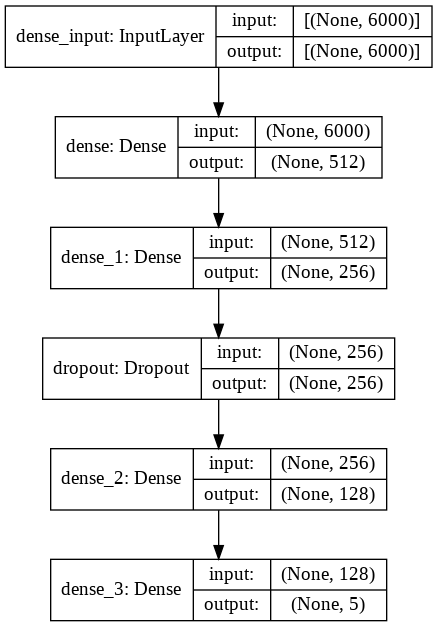

In [22]:
plot_model(acbsa_model, 'model_1.png',show_shapes=True)

In [23]:
#fit aspect classifier
history = acbsa_model.fit(X_train_tokenized , encoded_y_train , validation_data=(X_test_tokenized ,encoded_y_test) , epochs= 5, verbose=1)

Epoch 1/5
153/153 [==============================] - 5s 28ms/step - loss: 1.2093 - accuracy: 0.5392 - val_loss: 0.4169 - val_accuracy: 0.8744
Epoch 2/5
153/153 [==============================] - 4s 25ms/step - loss: 0.1704 - accuracy: 0.9513 - val_loss: 0.3205 - val_accuracy: 0.8998
Epoch 3/5
153/153 [==============================] - 4s 25ms/step - loss: 0.0308 - accuracy: 0.9942 - val_loss: 0.3994 - val_accuracy: 0.9138
Epoch 4/5
153/153 [==============================] - 4s 25ms/step - loss: 0.0075 - accuracy: 0.9976 - val_loss: 0.4321 - val_accuracy: 0.9163
Epoch 5/5
153/153 [==============================] - 4s 24ms/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 0.4563 - val_accuracy: 0.9138


In [24]:
predicted_cat = label_encoder.inverse_transform(acbsa_model.predict_classes(X_test_tokenized))
#print(new_polarity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [25]:
predicted_cat[0:10]

array(['anecdotes/miscellaneous', 'anecdotes/miscellaneous',
       'anecdotes/miscellaneous', 'anecdotes/miscellaneous', 'food',
       'food', 'price', 'food', 'anecdotes/miscellaneous', 'food'],
      dtype=object)

### 2.3 Classification report

In [26]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_cat ,target_names=catagories))

                         precision    recall  f1-score   support

                   food       0.97      0.85      0.90       164
anecdotes/miscellaneous       0.89      0.97      0.93       400
                service       0.93      0.90      0.91       355
               ambience       0.94      0.88      0.91       113
                  price       0.89      0.91      0.90       186

               accuracy                           0.91      1218
              macro avg       0.92      0.90      0.91      1218
           weighted avg       0.92      0.91      0.91      1218



### Observation : 
This is the classification report of aspect category based sentiment model showing the precision, recall, f1_score and support values for all 5 unique catagories with accuracy 91 percent 

In [28]:
import matplotlib.pyplot as plt
def plot_accuracy(history, miny=None):
  acc = history.history['accuracy']
  test_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  plt.plot(epochs, acc)
  plt.plot(epochs, test_acc)
  if miny:
    plt.ylim(miny, 1.0)
  plt.title('accuracy') 
  plt.xlabel('epoch')
  plt.figure()

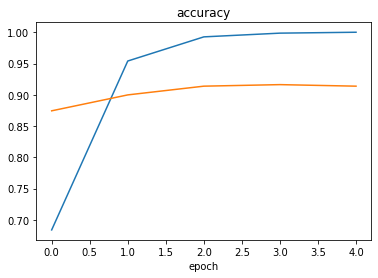

<Figure size 432x288 with 0 Axes>

In [29]:
plot_accuracy(history)

### 2.4.  Confusion matrix Representation

In [31]:
# code borrowed from Microsoft Malware Detection Assignment
def plot_confusion_matrix(test_y, predict_y ,labels):
    C = confusion_matrix(test_y, predict_y)      # calculation of confusion matrix 
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y))    # number of misclassified points while predicting y
 
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))

    labels = labels                 
    cmap=sns.light_palette("purple")
    # representing A in heatmap format
    print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    
    print("-"*50, "Precision matrix", "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of columns in precision matrix",B.sum(axis=0))

    # representing B in heatmap format
    print("-"*50, "Recall matrix" , "-"*50)
    plt.figure(figsize=(10,5))
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.show()
    print("Sum of rows in precision matrix",A.sum(axis=1))

Number of misclassified points  0.08620689655172414
-------------------------------------------------- Confusion matrix --------------------------------------------------


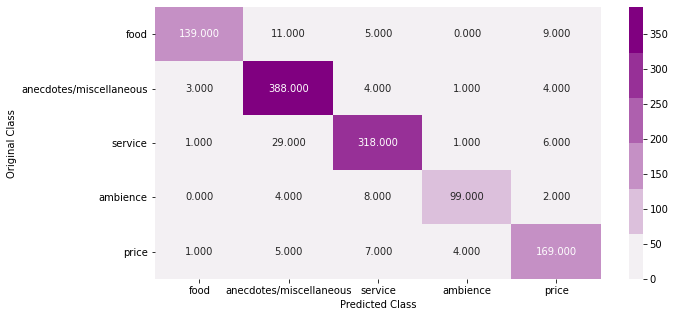

-------------------------------------------------- Precision matrix --------------------------------------------------


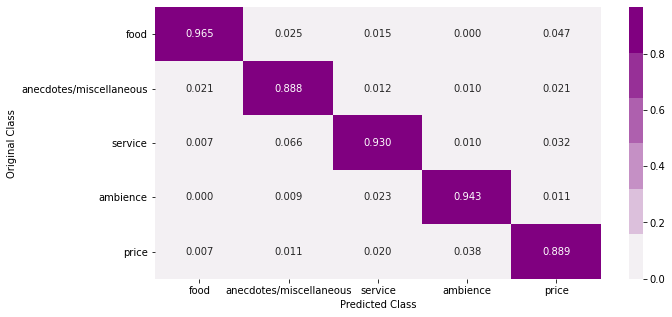

Sum of columns in precision matrix [1. 1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


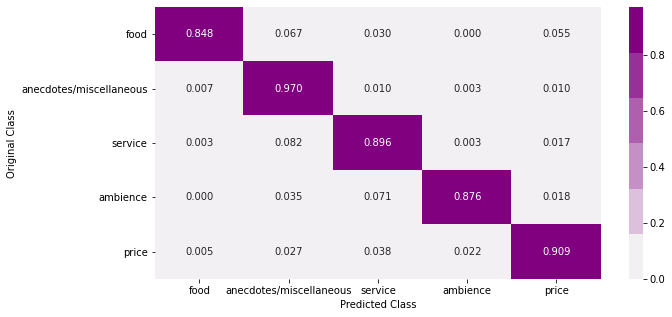

Sum of rows in precision matrix [1. 1. 1. 1. 1.]


In [32]:
plot_confusion_matrix(y_test,  predicted_cat, catagories)

## 3. Polarity Based sentiment model

In [34]:
X = restaurant_data['text']
Y = restaurant_data['polarity']

In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

In [36]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4870,) (4870,)
(1218,) (1218,)


In [37]:
label_encoder = LabelEncoder()
integer_category = label_encoder.fit_transform(y_train)
encoded_y_train = np_utils.to_categorical(integer_category)

integer_category = label_encoder.fit_transform(y_test)
encoded_y_test = np_utils.to_categorical(integer_category)

### 3.1 CNN sentiment model

In [38]:
sentiment_model = Sequential()
sentiment_model.add(Dense(512, input_shape=(6000,), activation='relu'))
sentiment_model.add((Dense(256, activation='relu')))
sentiment_model.add((Dropout(0.3)))
sentiment_model.add((Dense(128, activation='relu')))
sentiment_model.add(Dense(4, activation='softmax'))
sentiment_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [39]:
sentiment_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               3072512   
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 516       
Total params: 3,237,252
Trainable params: 3,237,252
Non-trainable params: 0
_________________________________________________________________


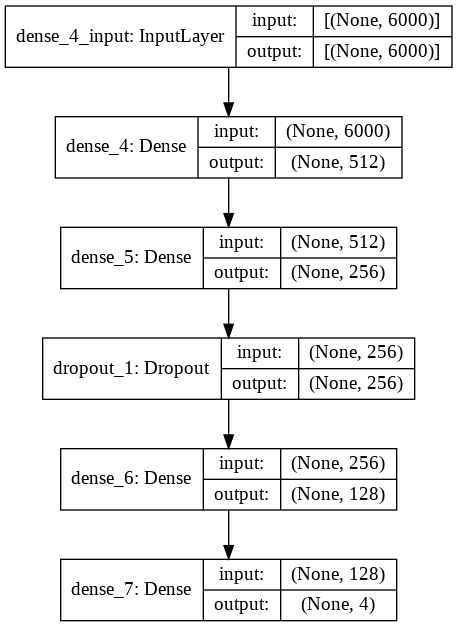

In [40]:
plot_model(sentiment_model, 'model_2.png',show_shapes=True)

In [41]:
#fit aspect classifier
history = sentiment_model.fit(X_train_tokenized , encoded_y_train , validation_data=(X_test_tokenized ,encoded_y_test) , epochs=6, verbose=1)

Epoch 1/6
153/153 [==============================] - 5s 27ms/step - loss: 1.0046 - accuracy: 0.5948 - val_loss: 0.4532 - val_accuracy: 0.8350
Epoch 2/6
153/153 [==============================] - 4s 25ms/step - loss: 0.2196 - accuracy: 0.9292 - val_loss: 0.3687 - val_accuracy: 0.8785
Epoch 3/6
153/153 [==============================] - 4s 25ms/step - loss: 0.0421 - accuracy: 0.9888 - val_loss: 0.4016 - val_accuracy: 0.9105
Epoch 4/6
153/153 [==============================] - 4s 26ms/step - loss: 0.0159 - accuracy: 0.9973 - val_loss: 0.4102 - val_accuracy: 0.9130
Epoch 5/6
153/153 [==============================] - 4s 26ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.4764 - val_accuracy: 0.9007
Epoch 6/6
153/153 [==============================] - 4s 25ms/step - loss: 0.0067 - accuracy: 0.9972 - val_loss: 0.5014 - val_accuracy: 0.9056


In [42]:
predicted_polarity = label_encoder.inverse_transform(sentiment_model.predict_classes(X_test_tokenized))
#print(new_polarity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [43]:
predicted_polarity[0:10]

array(['positive', 'positive', 'negative', 'neutral', 'positive',
       'positive', 'negative', 'positive', 'positive', 'conflict'],
      dtype=object)

In [44]:
polarity = restaurant_data["polarity"].unique()
polarity

array(['positive', 'negative', 'conflict', 'neutral'], dtype=object)

### 3.2 Classification repoort

In [45]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted_polarity ,target_names= polarity))

              precision    recall  f1-score   support

    positive       0.82      0.75      0.78        55
    negative       0.87      0.89      0.88       273
    conflict       0.85      0.82      0.84       177
     neutral       0.94      0.94      0.94       713

    accuracy                           0.91      1218
   macro avg       0.87      0.85      0.86      1218
weighted avg       0.91      0.91      0.91      1218



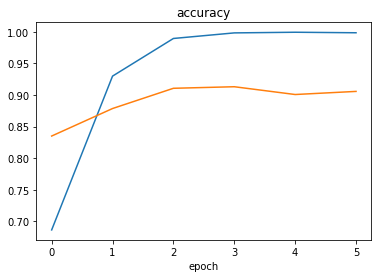

<Figure size 432x288 with 0 Axes>

In [46]:
plot_accuracy(history)

### 3.3 Confusion matrix representation

Number of misclassified points  0.09441707717569786
-------------------------------------------------- Confusion matrix --------------------------------------------------


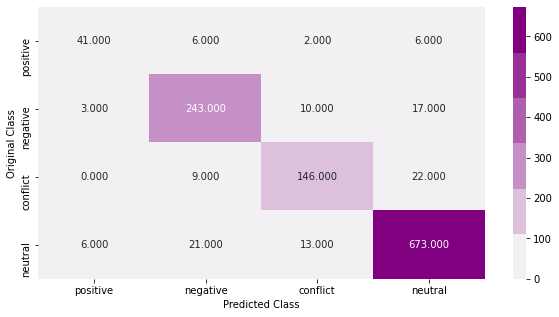

-------------------------------------------------- Precision matrix --------------------------------------------------


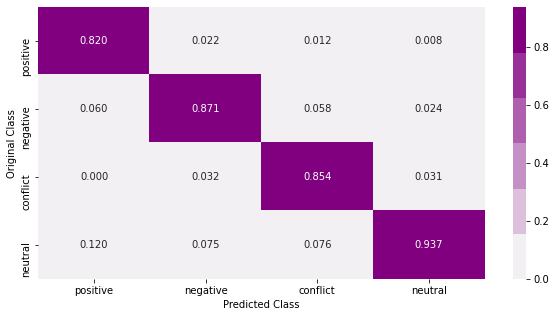

Sum of columns in precision matrix [1. 1. 1. 1.]
-------------------------------------------------- Recall matrix --------------------------------------------------


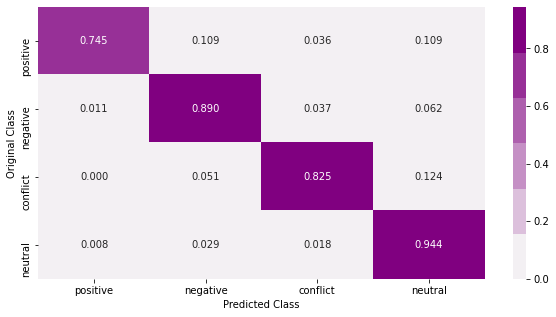

Sum of rows in precision matrix [1. 1. 1. 1.]


In [47]:
plot_confusion_matrix(y_test,  predicted_polarity, polarity)

## 4. creating a resultant dataframe

In [49]:
def create_result_dataframe(pred_1,pred_2):
  # Calling DataFrame constructor on predicted outputs
  resultant_df = pd.DataFrame(list(zip(pred_1,pred_2)), columns = ["predicted_catagories" , "predicted_polarity"])
  result  = pd.crosstab(resultant_df.predicted_catagories,resultant_df.predicted_polarity ,margins = True , margins_name = "Total")
  result["Ranking"] = ( result.Total/resultant_df.shape[0]) * 5.0 
  result["Negative in %"] = (result.negative/result.Total) * 100
  result["Neutral in %"] = (result.neutral/result.Total) * 100
  result["Positive in %"] = (result.positive/result.Total) * 100
  result["conflict in %"] = (result.conflict/result.Total) * 100
  del result["negative"]
  del result["neutral"]
  del result["positive"]
  del result["Total"]
  del result["conflict"]

  return result


In [50]:
result = create_result_dataframe(predicted_cat,predicted_polarity)

In [51]:
result

predicted_polarity,Ranking,Negative in %,Neutral in %,Positive in %,conflict in %
predicted_catagories,,,,,
ambience,0.591133,25.694444,5.555556,62.500000,6.250000
anecdotes/miscellaneous,1.793924,17.620137,27.917620,51.945080,2.517162
food,1.403941,16.081871,8.479532,71.345029,4.093567
price,0.431034,34.285714,3.809524,56.190476,5.714286
service,0.779967,38.947368,4.210526,51.578947,5.263158
Total,5.000000,22.906404,14.039409,58.949097,4.105090


### Observation :
   Above result shows that the Ranking and all Polarities in percentages for all aspect catagories from which we can see that anecdotes/miscellaneous have the highest ranking of 1.79 . and food catagory have highest positive polarity